In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from explorer_helper import *

# We expect big tables...
pd.options.display.max_rows = 999

# Server Executation

Example of server execution (disabled since HPC connection is not setup):

```python
settings.MODE = settings.MODES.SERVER
settings.SAVE = True

SGPR = {
    'name': 'SGPR',
    'kwargs': {
        'learning_rate': 0.1,
        'n_iter': 500,
        'nn_kwargs': {'layers': None},
        'gp_kwargs': {'inducing_points': 100},
        'use_double_precision': True,
    },
}

DKLSGPR = {
    'name': 'SGPR',
    'kwargs': {
        'do_pretrain': True,
        'pretrain_n_iter': 500,
        'learning_rate': 0.01,
        'n_iter': 300,
        'nn_kwargs': {'layers': [1]},
        'gp_kwargs': {'inducing_points': 100},
        'use_double_precision': True,
    },
}

transformer = {
    'name': 'ActiveSubspace',
    'kwargs': {
        'output_dim': 1
    }
}

models = [
    DKLSGPR,
    {
        'name': 'TransformerModel',
        'kwargs': {
            'transformer': transformer,
            'prob_model': SGPR,
        },
    },
]

functions = [
    {'name': 'ActiveSubspaceArbitrary1D', 'kwargs': {'D': 100}},
    {'name': 'ActiveSubspaceArbitrary1D', 'kwargs': {'D': 1000}},
 ]

for func in functions:
    for model in models:
        # Helper function to wraps all model in a NormalizerModel
        config = normalize_config({
            'tag': 'demo',
            'obj_func': func,
            'model': model,
            'gp_use_derivatives': model.get('name') == 'TransformerModel',
            'gp_samples': 20 * func.get('kwargs').get('D'),
        })
        run = execute(config_updates=config)
```

# Local Execution

WARNING - lions - No observers have been added to this run
INFO - lions - Running command 'main'
INFO - lions - Started
INFO - main - Model0: NormalizerModel training on 100 of dim 1
INFO - main - Iter 1/60 - Loss: 1.350
INFO - main - Iter 11/60 - Loss: 0.705


training on 100 data points of dim 1
Loss 1.3498951864794535 with hyperparameters: {'outputscale': array(0.69314718), 'lengthscale': array([[0.69314718]]), 'noise': 0.6932471805574191}


INFO - main - Iter 21/60 - Loss: 0.327
INFO - main - Iter 31/60 - Loss: -0.071
INFO - main - Iter 41/60 - Loss: -0.303


Loss -0.07146922695823008 with hyperparameters: {'outputscale': array(1.40128707), 'lengthscale': array([[0.30450495]]), 'noise': 0.05531465247706646}


INFO - main - Iter 51/60 - Loss: -0.244
INFO - main - Model0: NormalizerModel predicting on 2500 of dim 1
INFO - main - Model0: NormalizerModel has {'mae': 0.0037766779522875353, 'max_err': 0.0317096036378807, 'rmse': 0.005357994840417401, 'mnlp': -1.2203979263200804, 'nmse': 0.00040223777303090806}
INFO - main - Model0 has parameters: {'outputscale': array(1.89520734), 'lengthscale': array([[0.22823884]]), 'noise': 0.010806580604970657}


Using parameters with loss: -0.6994336041943143
predicting 2500 points using 100 training points
predicting 100 points using 100 training points


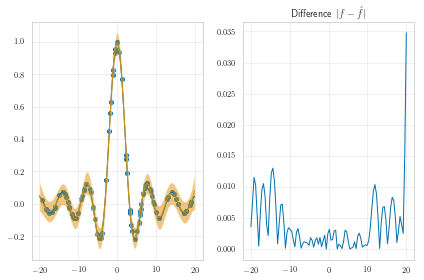

predicting 100 points using 100 training points


<Figure size 432x288 with 0 Axes>

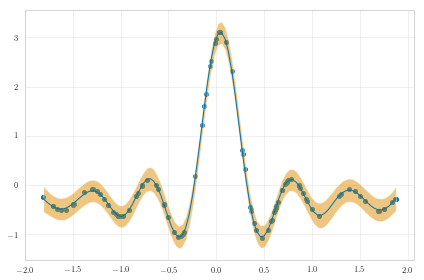

predicting 1000 points using 100 training points
predicting 1000 points using 100 training points


<Figure size 432x288 with 0 Axes>

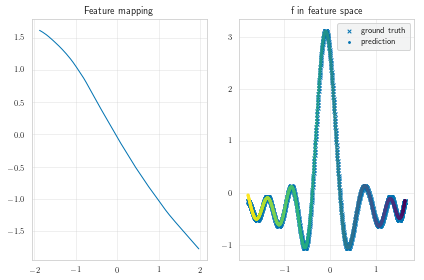

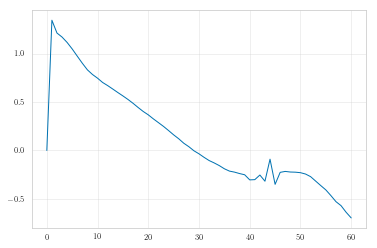

INFO - lions - Result: {'mae': 0.0037766779522875353, 'max_err': 0.0317096036378807, 'rmse': 0.005357994840417401, 'mnlp': -1.2203979263200804, 'nmse': 0.00040223777303090806, 'time:training': 4.983221999999998, 'time:pred': 0.3783980000000007, 'hyperparameters': {'outputscale': array(1.89520734), 'lengthscale': array([[0.22823884]]), 'noise': 0.010806580604970657}}
INFO - lions - Completed after 0:00:02


In [8]:
# Go into local mode.
settings.MODE = settings.MODES.LOCAL
settings.SAVE = False

# Specify the a [1000-1] DKL model using SGPR for scalability.
SGPR = {
    'name': 'SGPR',
    'kwargs': {
        'learning_rate': 0.1,
        'n_iter': 60,
        'nn_kwargs': {'layers': [1000,1]},
        'gp_kwargs': {'inducing_points': 100},
        'use_double_precision': True,
    },
}

# We automatically wrap the model in a normalixer model.
config = normalize_config({
    'tag': 'demo',
    'obj_func': {'name': 'Sinc'},
    'model': SGPR,
    'gp_samples': 100,
})
run = execute(config_updates=config)

## Exploration

predicting 100 points using 100 training points


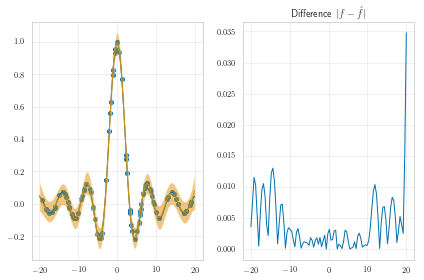

In [9]:
# We can now retrieve the objects for further inspection.
f = run.interactive_stash.obj_func
model = run.interactive_stash.model
fig = plot_model(model, f)

# Data exploration

In [10]:
# We can query the mongoDB.
# Here we illustrate with the results from "Linear Embeddings" in the thesis.
exps_rows_df = get_df(**{'config.tag': "final--embeddings-all"})

# All experiments with the same exp_hash are aggregated.
temp_df = aggregate_results(exps_rows_df)
temp_df = exps_rows_df

# We can then add columns specific for this particular collection of experiments.
def get_model_kwargs(row):
    kwargs = row.config.model.kwargs.model.kwargs.prob_model.get('kwargs', None)
    if kwargs is None:
        kwargs = row.config.model.kwargs.model.kwargs
    return kwargs

def get_lr(row):
    kwargs = get_model_kwargs(row)
    return kwargs.get('learning_rate', None)

def get_n_iter(row):
    kwargs = get_model_kwargs(row)
    return kwargs.get('n_iter', -1)

def get_layers(row):
    kwargs = get_model_kwargs(row)
    return kwargs.nn_kwargs.get('layers', None)

temp_df['f.n']      = temp_df.apply(lambda r: r.config.obj_func.kwargs.get('noise', 0), axis=1)
temp_df['lr_gamma'] = temp_df.apply(lambda r: r.config.model.kwargs.model.kwargs.get('steplr_gamma', 0.1), axis=1)
temp_df['steplr']   = temp_df.apply(lambda r: r.config.model.kwargs.model.kwargs.get('steplr_step_size', 999999), axis=1)
temp_df['wd']       = temp_df.apply(lambda r: r.config.model.kwargs.model.kwargs.get('weight_decay', -1), axis=1)
temp_df['clip']     = temp_df.apply(lambda r: r.config.model.kwargs.model.kwargs.get('grad_clip', -1), axis=1)
temp_df['act']      = temp_df.apply(lambda r: r.config.model.kwargs.model.kwargs.nn_kwargs.get('activation', ''), axis=1)
temp_df['f.D']      = temp_df.apply(lambda r: r.config.obj_func.kwargs.D, axis=1)
temp_df['n_iter']   = temp_df.apply(get_n_iter, axis=1)
temp_df['lr']       = temp_df.apply(get_lr, axis=1)
temp_df['pretrain'] = temp_df.apply(lambda r: r.config.model.kwargs.model.kwargs.get('do_pretrain', False), axis=1)
temp_df['layers']   = temp_df.apply(get_layers, axis=1)
temp_df['layers']   = temp_df.apply(lambda row: tuple(row.layers) if row.layers is not None else (), axis=1)

# We use a helper function to sort based on indexes and 'f'.
view_df(temp_df, 
        indexes=['f.n', 'f.D', 'model', 'layers', 'lr_gamma','steplr', 'lr', 'n_iter',  'wd', 'pretrain', 'act', 'clip', 'N'], 
        cols=['result.rmse', 'result.max_err','result.mae', 'id']).sort_index()

result.rmse  \
f.n  f.D  model                         layers             lr_gamma steplr lr   n_iter wd    pretrain act clip N     f                                            
0.00 50   N<DKLGPModel>                 (1,)               0.1      999999 0.01  3000  -1.00 False        -1   1000  ActiveSubspaceArbitrary1D50       0.000654   
                                        (1000, 500, 50, 1) 0.1      1000   0.01  2000   0.01 True          2   1000  ActiveSubspaceArbitrary1D50       0.002048   
                                                                                                                     ActiveSubspaceArbitrary1D50       0.002301   
          N<DNNBLR>                     (1000, 500, 50)    0.1      1000   0.01  2000   0.01 True          2   1000  ActiveSubspaceArbitrary1D50       0.032930   
                                        (1000, 500, 50, 1) 0.1      1000   0.01  2000   0.01 True          2   1000  ActiveSubspaceArbitrary1D50       0.007555   
                                                                                                                     ActiveSubspaceArbitrary1D50       0.004054   
                                                                                                                     ActiveSubspaceArbitrary1D50       0.004154   
                                                                                                                     ActiveSubspaceArbitrary1D50       0.004917   
                                                                                                                     ActiveSubspaceArbitrary1D50       0.005610   
                                        (1000, 500, 50, 5) 0.1      999999 0.01  2000   0.01 True          2   1000  ActiveSubspaceArbitrary1D50       0.010715   
          N<LASSO>                      ()                 0.1      999999 NaN  -1     -1.00 False        -1   1000  ActiveSubspaceArbitrary1D50       0.435326   
                                                                                                                     ActiveSubspaceArbitrary1D50       0.434930   
                                                                                                                     ActiveSubspaceArbitrary1D50       0.434927   
                                                                                                                     ActiveSubspaceArbitrary1D50       0.435049   
                                                                                                                     ActiveSubspaceArbitrary1D50       0.435319   
          N<LinearFromFeatureExtractor> (1000, 500, 50)    0.1      999999 0.01  3000   0.01 False        -1   1000  ActiveSubspaceArbitrary1D50       0.033879   
                                        (1000, 500, 50, 1) 0.1      999999 0.01  5000   0.01 False         2   1000  ActiveSubspaceArbitrary1D50       0.019462   
                                                                                                                     ActiveSubspaceArbitrary1D50       0.075350   
                                                                                                                     ActiveSubspaceArbitrary1D50       0.026696   
                                                                                                                     ActiveSubspaceArbitrary1D50       0.025862   
                                                                                                                     ActiveSubspaceArbitrary1D50       0.022710   
                                        (1000, 500, 50, 5) 0.1      999999 0.01  8000   0.01 False        -1   1000  ActiveSubspaceArbitrary1D50       0.019912   
          N<SGPR>                       (1,)               0.1      999999 0.01  3000  -1.00 True          2   1000  ActiveSubspaceArbitrary1D50       0.000394   
                                                                         

{'exp_hash': 'a0ab3a29107a6158d1f19f1e9da07feba7e6ea7e',
 'gp_samples': 20000,
 'gp_use_derivatives': False,
 'gpu': False,
 'model': {'kwargs': {'model': {'kwargs': {'do_pretrain': True,
                                           'eval_cg_tolerance': 1e-06,
                                           'gp_kwargs': {'inducing_points': 100},
                                           'grad_clip': 2,
                                           'learning_rate': 0.01,
                                           'max_cg_iter': 30000,
                                           'n_iter': 2000,
                                           'nn_kwargs': {'layers': [1000,
                                                                    500,
                                                                    50,
                                                                    1]},
                                           'noise': None,
                                           'noise_lower_boun

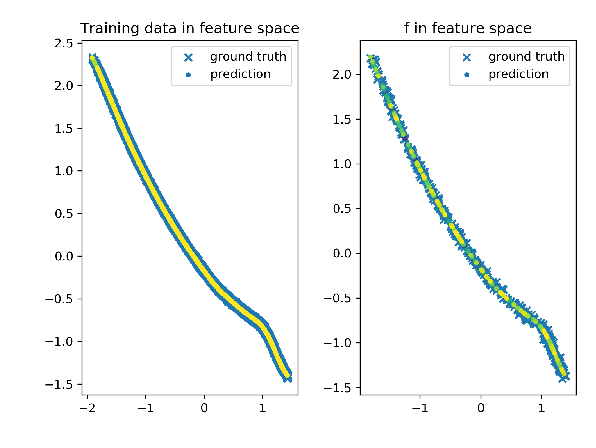

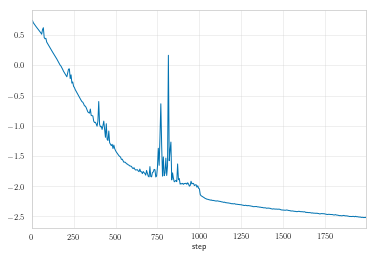

In [11]:
# Inspect an experiment with a particular 
view_experiment_with_id(temp_df, 4304)

In [15]:
def format_layer_list(layers):
    return '[' +  "-".join(map(str,layers)) + ']'

def create_display_df(cols=['RMSE', 'MAX', 'MNLP', 'Time (s)'], noise=False):
    exps_rows_df2 = exps_rows_df
    exps_rows_df2 = exps_rows_df2[exps_rows_df2['model'] != 'N<DKLGPModel>']
    exps_rows_df2['has_noise'] = exps_rows_df2.apply(lambda r: bool(r.config.obj_func.kwargs.get('noise', False)),axis=1)
    if noise:
        exps_rows_df2 = exps_rows_df2[exps_rows_df2['has_noise']]
    else:
        exps_rows_df2 = exps_rows_df2[~exps_rows_df2['has_noise']]
    exps_rows_df2 = exps_rows_df2[exps_rows_df2['layers'].isin([(), (1000,500,50,1), (1,)])]
    exps_rows_df2 = exps_rows_df2[~np.isclose(exps_rows_df2['lr_gamma'], 0.5)]
    exps_rows_df2 = exps_rows_df2[exps_rows_df2['steplr'] != 700]

    temp_df = aggregate_result_std(exps_rows_df2, col='result.rmse', format="{:.5f}")
    temp_df['RMSE'] = temp_df['result.rmse.describe']
    temp_df['MAX'] = aggregate_result_std(exps_rows_df2, col='result.max_err', format="{:.6f}")['result.max_err.describe']
    temp_df['MNLP'] = aggregate_result_std(exps_rows_df2, col='result.mnlp', format="{:.3f}")['result.mnlp.describe']
    temp_df['Time (s)'] = aggregate_result_std(exps_rows_df2, col='result.time:training', format="{:.0f}")['result.time:training.describe']

    def get_display_name(r):
        NAMES = {
            'N<T<ActiveSubspace,SGPR>>': 'AS-GP',
            'N<SGPR>': 'DKL',
            'N<LASSO>': 'LASSO',
            'N<DNNBLR>': 'DNNBLR',
            'N<LinearFromFeatureExtractor>': 'DNN',
        }
        name = NAMES[r['model']]
        if name in ['DKL', 'DNNBLR', 'DNN']:
            return name + ' ' + format_layer_list(r['layers'])
        return name

    # Summaries taps    
    temp_df['layers'] = temp_df.apply(get_layers, axis=1)
    temp_df['layers'] = temp_df.apply(lambda row: tuple(row.layers) if row.layers is not None else (), axis=1)

    temp_df['Model'] = temp_df.apply(get_display_name, axis=1)
    temp_df['f'] = temp_df['f.D']

    display_df = view_df(temp_df, indexes=['Model'], cols=cols, ).sort_index()
    display_df = display_df.rename_axis(['Model', 'D'])
    return display_df

display_df = create_display_df(noise=False)
display_df

RMSE                  MAX  \
Model                  D                                              
AS-GP                  50    0.00150 ± 0.00017  0.007968 ± 0.000772   
                       100   0.00070 ± 0.00024  0.003307 ± 0.001315   
                       500   0.00015 ± 0.00004  0.000711 ± 0.000150   
                       1000  0.00008 ± 0.00001  0.000360 ± 0.000058   
DKL [1000-500-50-1]    50    0.00184 ± 0.00006  0.038482 ± 0.009060   
                       100   0.00226 ± 0.00106  0.025174 ± 0.014882   
                       500   0.00253 ± 0.00167  0.016710 ± 0.016364   
                       1000  0.00478 ± 0.00308  0.029156 ± 0.022973   
DKL [1]                50    0.00042 ± 0.00002  0.002468 ± 0.000952   
                       100   0.00038 ± 0.00004  0.002101 ± 0.000468   
                       500   0.00049 ± 0.00009  0.002372 ± 0.000512   
                       1000  0.00055 ± 0.00003  0.002632 ± 0.000132   
DNN [1000-500-50-1]    50    0.03402 ± 0.02328  0.182243 ± 0.057918   
                       100   0.02786 ± 0.00688  0.126487 ± 0.013855   
                       500   0.03712 ± 0.00327  0.126506 ± 0.012235   
                       1000  0.07013 ± 0.06383  0.217671 ± 0.156333   
DNNBLR [1000-500-50-1] 50    0.00526 ± 0.00143  0.061852 ± 0.008545   
                       100   0.00902 ± 0.00672  0.060456 ± 0.029185   
                       500   0.00751 ± 0.00628  0.050739 ± 0.051432   
                       1000  0.00418 ± 0.00108  0.026866 ± 0.016963   
LASSO                  50    0.43511 ± 0.00020  1.332370 ± 0.012745   
                       100   0.43486 ± 0.00031  1.141679 ± 0.013556   
                       500   0.43254 ± 0.00004  1.019264 ± 0.004758   
                       1000  0.43120 ± 0.00003  0.978708 ± 0.002359   

                                       MNLP   Time (s)  
Model                  D                                
AS-GP                  50    -2.341 ± 0.062    63 ± 14  
                       100   -2.763 ± 0.171    72 ± 29  
                       500   -3.508 ± 0.137  134 ± 159  
                       1000  -3.882 ± 0.109  158 ± 230  
DKL [1000-500-50-1]    50    -1.796 ± 0.045    111 ± 0  
                       100   -1.805 ± 0.130    112 ± 7  
                       500   -1.731 ± 0.067    203 ± 6  
                       1000  -1.632 ± 0.118   310 ± 15  
DKL [1]                50    -2.947 ± 0.016   151 ± 11  
                       100   -3.003 ± 0.032    154 ± 5  
                       500   -2.941 ± 0.089    193 ± 5  
                       1000  -2.893 ± 0.029   217 ± 13  
DNN [1000-500-50-1]    50       nan ± 0.000     21 ± 0  
                       100      nan ± 0.000     27 ± 0  
                       500      nan ± 0.000     74 ± 2  
                       1000     nan ± 0.000    152 ± 7  
DNNBLR [1000-500-50-1] 50    -1.684 ± 0.076     54 ± 1  
                       100   -1.241 ± 0.823     59 ± 0  
                       500   -1.432 ± 0.567    127 ± 2  
                       1000  -1.712 ± 0.045    210 ± 2  
LASSO                  50       nan ± 0.000      0 ± 0  
                       100      nan ± 0.000      0 ± 0  
                       500      nan ± 0.000      0 ± 0  
                       1000     nan ± 0.000      1 ± 0

In [16]:
save_table(display_df.to_latex(
    multicolumn=True, 
    multirow=True, 
    escape=False, 
    bold_rows=True, 
    column_format='llccc'), 'demo')

\begin{tabular}{llccc}
\toprule
      &      &               RMSE &                  MAX &            MNLP &   Time (s) \\
\textbf{Model} & \textbf{D} &                    &                      &                 &            \\
\midrule
\multirow{4}{*}{\textbf{AS-GP}} & \textbf{50  } &  0.00150 ± 0.00017 &  0.007968 ± 0.000772 &  -2.341 ± 0.062 &    63 ± 14 \\
      & \textbf{100 } &  0.00070 ± 0.00024 &  0.003307 ± 0.001315 &  -2.763 ± 0.171 &    72 ± 29 \\
      & \textbf{500 } &  0.00015 ± 0.00004 &  0.000711 ± 0.000150 &  -3.508 ± 0.137 &  134 ± 159 \\
      & \textbf{1000} &  0.00008 ± 0.00001 &  0.000360 ± 0.000058 &  -3.882 ± 0.109 &  158 ± 230 \\
\cline{1-6}
\multirow{4}{*}{\textbf{DKL [1000-500-50-1]}} & \textbf{50  } &  0.00184 ± 0.00006 &  0.038482 ± 0.009060 &  -1.796 ± 0.045 &    111 ± 0 \\
      & \textbf{100 } &  0.00226 ± 0.00106 &  0.025174 ± 0.014882 &  -1.805 ± 0.130 &    112 ± 7 \\
      & \textbf{500 } &  0.00253 ± 0.00167 &  0.016710 ± 0.016364 &  -1.731 ± 0.067 

# Inspect Status

In [21]:
df = get_df(**{'config.tag': 'final--embeddings-all'})
df['captured_out'] = df.apply(lambda r: r.exp.captured_out, axis=1)
df['heartbeat'] = df.apply(lambda r: r.exp.heartbeat, axis=1)
df['start'] = df.apply(lambda r: r.exp.start_time, axis=1)
df['duration'] = df.apply(lambda r: (r.exp.heartbeat - r.exp.start_time) if not pd.isnull(r.exp.heartbeat) else 0, axis=1)
df['newest loss'] = df.apply(lambda r: r.exp.metrics.get('DKLGPModel.training.loss', pd.Series([None])).iloc[-1], axis=1)

df[['status', 'id', 'model', 'duration', 'newest loss' ,'tag']]

,status,id,model,duration,newest loss,tag
exp_hash,,,,,,
026a2951111d51a4096e5ab6b1d949e14d2543ba,COMPLETED,3950,N<SGPR>,0:02:05.020000,-2.617028,final--embeddings-all
02de1d86025d0112a5991109056d796aaef69dbc,COMPLETED,3921,N<LinearFromFeatureExtractor>,0:00:10.243000,0.000368,final--embeddings-all
0ab9592ff518896f7c6be91eeaefc98a7ebe44db,COMPLETED,4167,N<SGPR>,0:04:45.208000,-2.800441,final--embeddings-all
0ab9592ff518896f7c6be91eeaefc98a7ebe44db,COMPLETED,4223,N<SGPR>,0:04:41.079000,-2.653586,final--embeddings-all
0ab9592ff518896f7c6be91eeaefc98a7ebe44db,COMPLETED,4195,N<SGPR>,0:04:41.641000,-2.578497,final--embeddings-all
0ab9592ff518896f7c6be91eeaefc98a7ebe44db,COMPLETED,4141,N<SGPR>,0:04:30.553000,-2.567107,final--embeddings-all
0cc9146c9be4f3a16c4f29bb8bd73d0243a99749,COMPLETED,4206,N<LASSO>,0:00:02.517000,NaN,final--embeddings-all
0cc9146c9be4f3a16c4f29bb8bd73d0243a99749,COMPLETED,3506,N<LASSO>,0:00:00.482000,NaN,final--embeddings-all
0cc9146c9be4f3a16c4f29bb8bd73d0243a99749,COMPLETED,4150,N<LASSO>,0:00:02.443000,NaN,final--embeddings-all
